# Estimating country means

Ultimately, retrieving the ATE can be seen as determining the (possibly weighted) means of two subsets: treated and control. As we will see, using the mean of model predictions for the subset, $\mathbb{E}[\hat{Y} \mid i \in S]$, will be a biased estimate of $\mathbb{E}[Y \mid i \in S]$ due to $Y - \hat{Y} \not\perp Y$. To study this phenomenon, we would like to estimate the mean of some of subsets with and without our Tweedies' based debiasing formula. The subsets need to be meaningful, so in this notebook we will make use of the country labels to estimate the mean IWI for each country. The hypothesis is that the mean of the predicted estimates will be biased in regards to the true wealth, such that the predicted mean will be too high for poor countries and too low for rich countries. The hope is for the Tweedie's adjusted predictions to remove this bias.

In [1]:
import os
import configparser
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from utils import RegressionModel, train_model, plot_results
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

sns.set_theme()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Read config file
config = configparser.ConfigParser()
config.read('../config.ini')

DATA_DIR = config['PATHS']['DATA_DIR']

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load the image embeddings and DHS information for our small dataset (10k entries). Randomly split into training and test set.

In [2]:
RANDOM_STATE = 42
N_COMPONENTS = 232

embeddings = np.load(os.path.join(DATA_DIR, 'ssl4eo_resnet50.npy'))
df = pd.read_csv(os.path.join(DATA_DIR, 'dhs_with_imgs.csv'))

assert embeddings.shape[0] == df.shape[0], 'Mismatch between embeddings and metadata rows.'

X = embeddings

# Cheat by doing rescaling and PCA on the whole set
scaler = StandardScaler()
X = scaler.fit_transform(X)
pca = PCA(n_components=N_COMPONENTS)
X = pca.fit_transform(X)

Y = df['iwi'].values / 100.0 # Scale IWI to [0, 1]
Y = Y.clip(0, 1)

X = torch.tensor(X, dtype=torch.float).to(device)
Y = torch.tensor(Y, dtype=torch.float).to(device)

X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(X, Y, df, test_size=0.2, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val, df_train, df_val = train_test_split(X_train, y_train, df_train, test_size=0.2, random_state=RANDOM_STATE)

Train NN model with MSE using the training set.

 13%|█▎        | 6625/50000 [00:14<01:31, 472.20it/s]


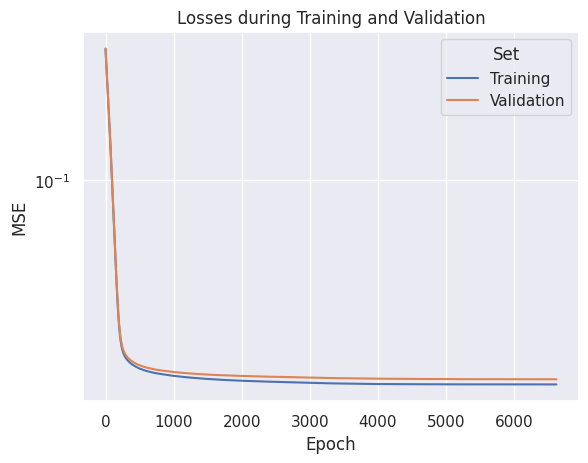

In [3]:
# Example of a loss function that only tracks one metric (MSE)
def mse_loss(pred, target):
    mse = nn.MSELoss()(pred, target)
    return mse, {'MSE': mse.item()}

mse_model = train_model(X_train, X_val, y_train, y_val, lr=1e-4, l2=1e-2, loss_fn=mse_loss, verbose=1)

Plot results for the test set. We will see a positive correlation between $Y$ and $Y - \hat{Y}$, suggesting that we overestimate the wealth of poor location and underestimate for wealth loications.

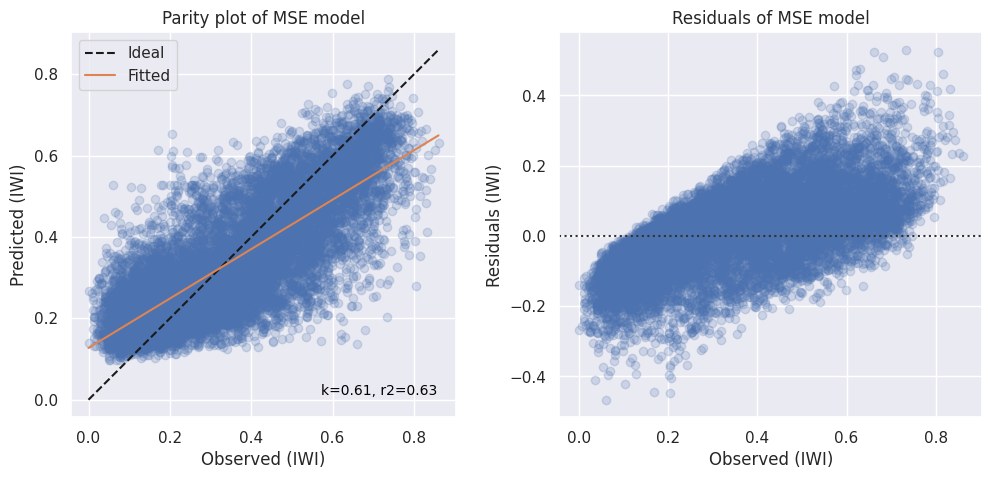

In [4]:
with torch.no_grad():
    y_pred = mse_model(X_test)
    
plot_results(y_test, y_pred, 'MSE model')

Rescale IWI to [0, 100]

In [5]:
targets = 100 * y_test.cpu().numpy()
predictions = 100 * y_pred.cpu().numpy()

Plot parity plots for each country in the test set

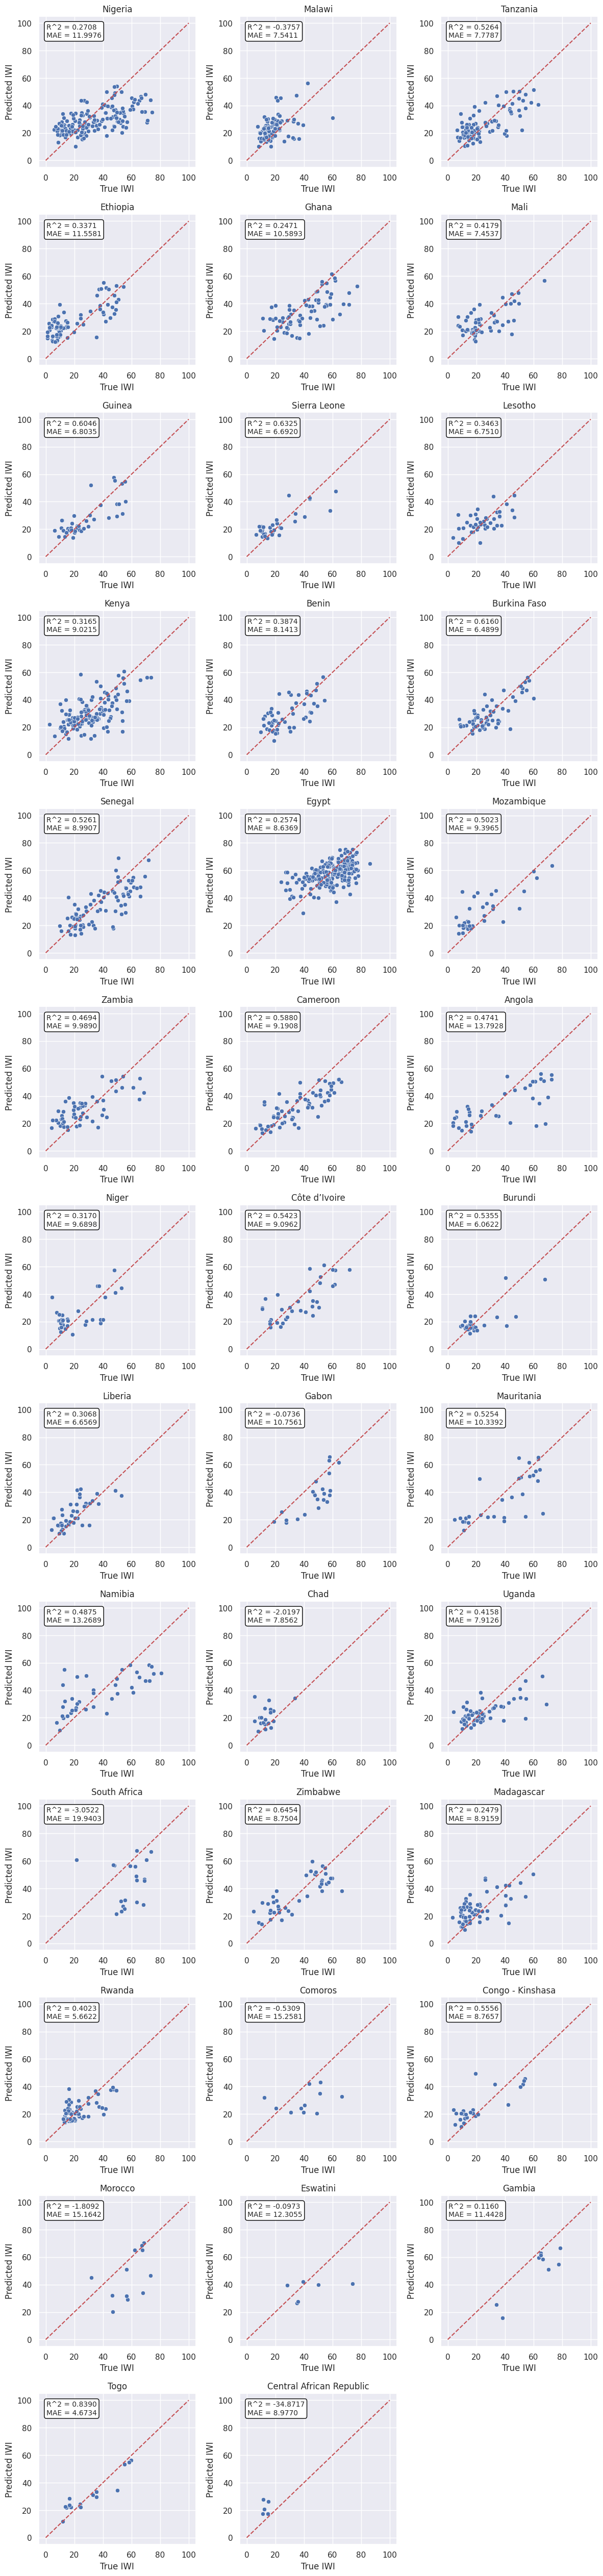

In [6]:
countries = df_test['country'].unique()

# Plot all scatter plots
plt.figure(figsize=(12, 4/3 * len(countries)))
for i, country in enumerate(countries):
    plt.subplot(len(countries) // 3 + 1, 3, i + 1)
    country_mask = df_test['country'] == country
    country_targets = targets[country_mask]
    country_predictions = predictions[country_mask]
    
    sns.scatterplot(x=country_targets, y=country_predictions)
    # Add label with r^2 and MAE to plot
    r2 = r2_score(country_targets, country_predictions)
    mae = mean_absolute_error(country_targets, country_predictions)
    plt.text(0.05, 0.95, f'R^2 = {r2:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
    # Add diagonal line
    plt.plot([0, 100], [0, 100], 'r--')
    plt.title(country)
    plt.xlabel('True IWI')
    plt.ylabel('Predicted IWI')
plt.tight_layout()

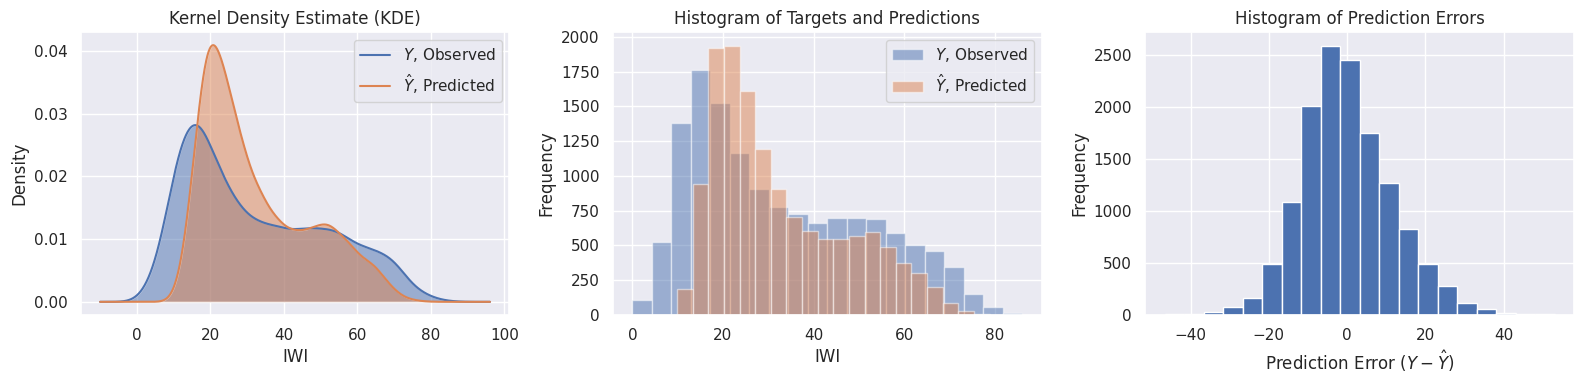

In [6]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

# Create KDE for marginal density p_Y(y)
target_kde = gaussian_kde(targets)
pred_kde = gaussian_kde(predictions)

# Create a range of x values to evaluate the KDE over
y_values = np.linspace(min(targets)-10, max(targets)+10, 1000)

# Evaluate the KDE over these x values
target_kde_values = target_kde(y_values)
pred_kde_values = pred_kde(y_values)

plt.figure(figsize=(16, 4))

# Plot the KDE
plt.subplot(1, 3, 1)
plt.plot(y_values, target_kde_values, label="$Y$, Observed")
plt.fill_between(y_values, target_kde_values, alpha=0.5)
plt.plot(y_values, pred_kde_values, label="$\hat{Y}$, Predicted")
plt.fill_between(y_values, pred_kde_values, alpha=0.5)
plt.title("Kernel Density Estimate (KDE)")
plt.xlabel("IWI")
plt.ylabel("Density")
plt.legend()

# Plot histogram of targets and predictions
plt.subplot(1, 3, 2)
plt.hist(targets, bins=20, alpha=0.5, label="$Y$, Observed")
plt.hist(predictions, bins=20, alpha=0.5, label="$\hat{Y}$, Predicted")
plt.title('Histogram of Targets and Predictions')
plt.xlabel('IWI')
plt.ylabel('Frequency')
plt.legend()

# Plot histogram of prediction errors
plt.subplot(1, 3, 3)
plt.hist(targets - predictions, bins=20)
plt.title('Histogram of Prediction Errors')
plt.xlabel('Prediction Error $(Y - \hat{Y})$')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Plot the score functions for $Y$ and $\hat{Y}$. The score function for $\hat{Y}$ will be used for adjusting the predictions

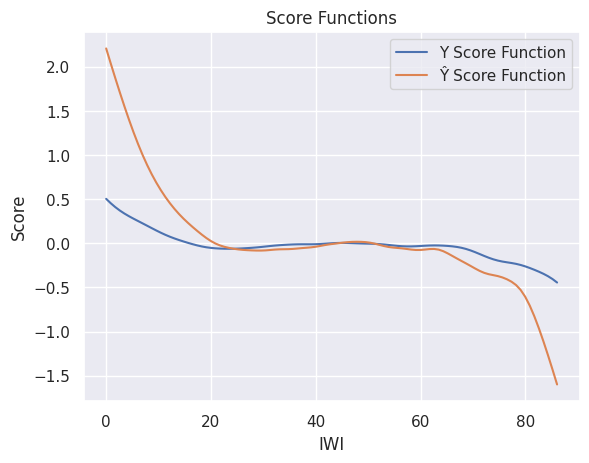

In [7]:
# Define evaluation points (avoid extreme values)
lower = np.percentile(targets, 2.5)
upper = np.percentile(targets, 97.5)
y_vals = np.linspace(min(targets), max(targets), 100)

# Finite difference step for derivative
delta = 1e-5

scores = []
pred_scores = []

def score_function(y, kde, delta=1e-5):
    # Derivative of log density
    log_p_plus = kde.logpdf(y + delta)[0]
    log_p_minus = kde.logpdf(y - delta)[0]
    d_logp = (log_p_plus - log_p_minus) / (2 * delta)
    return d_logp

for y in y_vals:
    
    # Derivative of log density for targets
    scores.append(score_function(y, target_kde))

    # Derivative of log density for predictions
    pred_scores.append(score_function(y, pred_kde))

# Plot score function
plt.plot(y_vals, scores, label="Y Score Function")
plt.plot(y_vals, pred_scores, label="Ŷ Score Function")
plt.title("Score Functions")
plt.xlabel("IWI")
plt.ylabel("Score")
plt.legend()
plt.show()

The adjustment also required us to know the variance of the residuals. We get these from the validation set.

In [8]:
with torch.no_grad():
    val_predictions = mse_model(X_val).cpu().numpy()
    val_targets = y_val.cpu().numpy()
    val_predictions = val_predictions * 100
    val_targets = val_targets * 100

    res_std = (val_predictions - val_targets).std()

print('Var(Y - Y-hat):', res_std)

Var(Y - Y-hat): 11.679033


Calculate the score for each predicted point

In [9]:
prediction_scores = np.array([score_function(y, pred_kde) for y in predictions])

Calculate three means for each country:

- The mean of the labels $Y$
- The mean of the predictions $\hat{Y}$
- The mean of the predictions adjusted by our "Tweedie's adjustment"

In [19]:
from sklearn.linear_model import LinearRegression

km_regressor = LinearRegression()
km_regressor.fit(val_targets.reshape(-1, 1), val_predictions)

k = km_regressor.coef_[0]
m = km_regressor.intercept_
print(f'Estimated slope (k): {k:.4f}')
print(f'Estimated intercept (m): {m:.4f}')

Estimated slope (k): 0.6031
Estimated intercept (m): 12.7282


In [38]:
regions = df_test.groupby('region_id').size() 
regions[regions > 5].index

Index(['AO.Benguela', 'AO.Bié', 'AO.Cabinda', 'AO.Cuando Cubango',
       'AO.Cuanza Norte', 'AO.Cuanza Sul', 'AO.Cunene',
       'AO.Estavel Mesoendemica', 'AO.Hiper Endemica', 'AO.Huambo',
       ...
       'ZW.Manicaland', 'ZW.Mashonaland Central', 'ZW.Mashonaland East',
       'ZW.Mashonaland West', 'ZW.Masvingo', 'ZW.Matabeleland North',
       'ZW.Matabeleland South', 'ZW.Matebeleland North',
       'ZW.Matebeleland South', 'ZW.Midlands'],
      dtype='object', name='region_id', length=508)

In [48]:
target_means = []
prediction_means = []
adjusted_prediction_means = []

regions = df_test.groupby('region_id').size() 
regions = regions[regions > 5].index

countries = regions

for country in countries:
    country_mask = df_test['region_id'] == country

    country_target_mean = targets[country_mask].mean()
    country_pred_mean = predictions[country_mask].mean()

    adjusted_pred_country_mean = country_pred_mean - res_std**2 * prediction_scores[country_mask].mean()

    target_means.append(country_target_mean)
    prediction_means.append(country_pred_mean)
    adjusted_prediction_means.append(adjusted_pred_country_mean)

target_means = np.array(target_means)
prediction_means = np.array(prediction_means)
adjusted_prediction_means = np.array(adjusted_prediction_means)
lcc_adjusted_prediction_means = (prediction_means - m) / k

Plot the three predictions

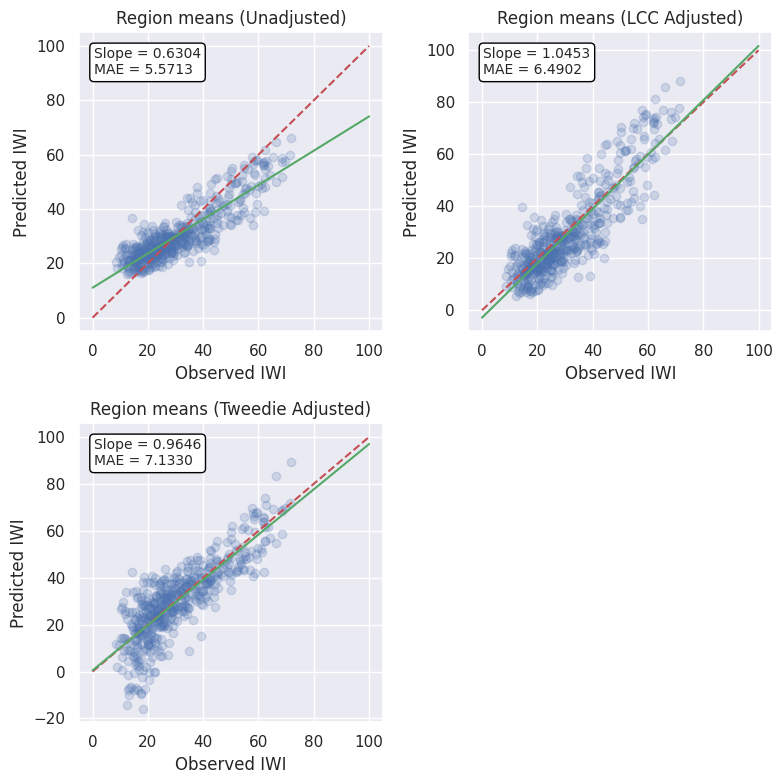

In [49]:
# Plot the ATEs
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
# Plot points colored by funder (red for CH, blue for WB)
plt.scatter(target_means, prediction_means, alpha=0.2) #, c=trials_df['funder'].map({'CH': 'red', 'WB': 'blue'}))
# Add label with slope and MAE to plot
slope, _ = np.polyfit(target_means, prediction_means, 1)
mae = mean_absolute_error(target_means, prediction_means)
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([0, 100], [0, 100], 'r--')
plt.plot([0, 100], [_, _ + slope * 100], 'g-')  # Adjusted line based on slope and intercept
plt.xlabel('Observed IWI')
plt.ylabel('Predicted IWI')
plt.title('Region means (Unadjusted)')

plt.subplot(2, 2, 2)
# Plot points colored by funder (red for CH, blue for WB)
plt.scatter(target_means, lcc_adjusted_prediction_means, alpha=0.2) #, c=trials_df['funder'].map({'CH': 'red', 'WB': 'blue'}))
# Add label with slope and MAE to plot
slope, _ = np.polyfit(target_means, lcc_adjusted_prediction_means, 1)
mae = mean_absolute_error(target_means, lcc_adjusted_prediction_means)
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([0, 100], [0, 100], 'r--')
plt.plot([0, 100], [_, _ + slope * 100], 'g-')  # Adjusted line based on slope and intercept
plt.xlabel('Observed IWI')
plt.ylabel('Predicted IWI')
plt.title('Region means (LCC Adjusted)')

plt.subplot(2, 2, 3)
# Plot points colored by funder (red for CH, blue for WB)
plt.scatter(target_means, adjusted_prediction_means, alpha=0.2) #, c=trials_df['funder'].map({'CH': 'red', 'WB': 'blue'}))
# Add label with slope and MAE to plot
slope, _ = np.polyfit(target_means, adjusted_prediction_means, 1)
mae = mean_absolute_error(target_means, adjusted_prediction_means)
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([0, 100], [0, 100], 'r--')
plt.plot([0, 100], [_, _ + slope * 100], 'g-')  # Adjusted line based on slope and intercept
plt.xlabel('Observed IWI')
plt.ylabel('Predicted IWI')
plt.title('Region means (Tweedie Adjusted)')
'''
plt.subplot(2, 2, 2)
# Plot points colored by funder (red for CH, blue for WB)
plt.scatter(trials_df['ate'].values, trials_df['trial_ate_hat_tweedie'].values) #, c=trials_df['funder'].map({'CH': 'red', 'WB': 'blue'}))
# Add label with slope and MAE to plot
slope, _ = np.polyfit(trials_df['ate'].values, trials_df['trial_ate_hat_tweedie'].values, 1)
mae = mean_absolute_error(trials_df['ate'].values, trials_df['trial_ate_hat_tweedie'].values)
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([0, 100], [0, 100], 'r--')
plt.xlabel('ATE with observed IWI')
#plt.ylabel('ATE with predicted IWI')
plt.title('MSE Model (Tweedie Adjusted)')

plt.subplot(2, 2, 3)
# Plot points colored by funder (red for CH, blue for WB)
plt.scatter(trials_df['ate'].values, trials_df['trial_ate_hat_lcc'].values) #, c=trials_df['funder'].map({'CH': 'red', 'WB': 'blue'}))
# Add label with slope and MAE to plot
slope, _ = np.polyfit(trials_df['ate'].values, trials_df['trial_ate_hat_lcc'].values, 1)
mae = mean_absolute_error(trials_df['ate'].values, trials_df['trial_ate_hat_lcc'].values)
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([0, 100], [0, 100], 'r--')
plt.xlabel('ATE with observed IWI')
plt.ylabel('ATE with predicted IWI')
plt.title('MSE Model (LCC Adjusted)')

plt.subplot(2, 2, 4)
# Plot points colored by funder (red for CH, blue for WB)
# Drop NaN values from the DataFrame
ppi_trials_df = trials_df.dropna(subset=['trial_ate_hat_ppi'])
plt.scatter(ppi_trials_df['ate'].values, ppi_trials_df['trial_ate_hat_ppi'].values) #, c=ppi_trials_df['funder'].map({'CH': 'red', 'WB': 'blue'}))
# Add label with slope and MAE to plot
slope, _ = np.polyfit(ppi_trials_df['ate'].values, ppi_trials_df['trial_ate_hat_ppi'].values, 1)
mae = mean_absolute_error(ppi_trials_df['ate'].values, ppi_trials_df['trial_ate_hat_ppi'].values)
plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([0, 100], [0, 100], 'r--')
plt.xlabel('ATE with observed IWI')
#plt.ylabel('ATE with predicted IWI')
plt.title('MSE Model (PPI Adjusted)')
'''
plt.tight_layout()
plt.show()

Plot the true country means (from $Y$) vs the predicted means with and without Tweedie's adjustment.

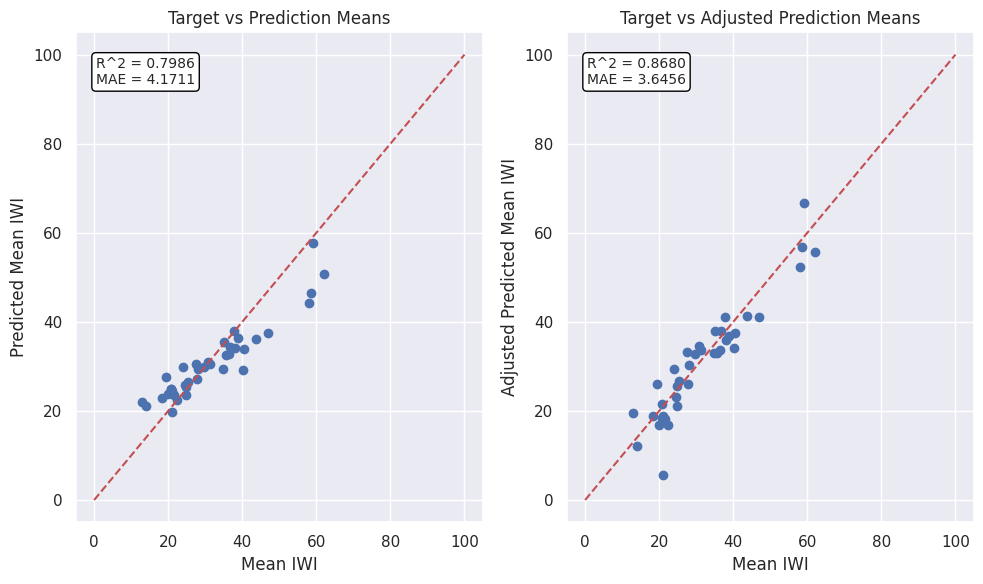

In [ ]:
# Plot the target vs prediction means
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.scatter(target_means, prediction_means)
# Add label with r^2 and MAE to plot
r2 = r2_score(target_means, prediction_means)
mae = mean_absolute_error(target_means, prediction_means)
plt.text(0.05, 0.95, f'R^2 = {r2:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([0, 100], [0, 100], 'r--')
plt.xlabel('Mean IWI')
plt.ylabel('Predicted Mean IWI')
plt.title('Target vs Prediction Means')

plt.subplot(1, 2, 2)
plt.scatter(target_means, adjusted_prediction_means)
# Add label with r^2 and MAE to plot
r2 = r2_score(target_means, adjusted_prediction_means)
mae = mean_absolute_error(target_means, adjusted_prediction_means)
plt.text(0.05, 0.95, f'R^2 = {r2:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([0, 100], [0, 100], 'r--')
plt.xlabel('Mean IWI')
plt.ylabel('Adjusted Predicted Mean IWI')
plt.title('Target vs Adjusted Prediction Means')
plt.tight_layout()
plt.show()

As we can see, prior to the adjustment, the country mean estimated are biased towards the "mean of means". The adjusted prediction means show no such bias.

To highlight this, we calculate the f-statistic for the predicted means being the same as the true means

In [23]:
from scipy.stats import f
from sklearn.linear_model import LinearRegression

def f_statistic(X, Y):

    n = len(Y)

    # Restricted model: Y = X (slope fixed at 1, intercept fixed at 0)
    RSS_R = np.sum((Y - X)**2)

    # Unrestricted model: Estimate slope (k) and intercept (m)
    reg = LinearRegression()
    reg.fit(X.reshape(-1, 1), Y)
    fitted_Y = reg.predict(X.reshape(-1, 1))
    RSS_UR = np.sum((Y - fitted_Y)**2)

    # 3. Compute the F statistic
    q = 2  # number of restrictions: m=0 and k=1
    p = 2  # parameters in unrestricted model
    F_stat = ((RSS_R - RSS_UR) / q) / (RSS_UR / (n - p))

    # Compute the p-value for the F-test
    p_value = 1 - f.cdf(F_stat, q, n - p)

    print(f'Estimated slope (k):, {reg.coef_[0]:.4f}')
    print(f'Estimated intercept (m):, {reg.intercept_:.4f}')
    print(f'RSS of Restricted model (k=1, m=0):, {RSS_R:.4f}')
    print(f'RSS of Unrestricted model:, {RSS_UR:.4f}')
    print(f'F-statistic:, {F_stat:.4f}')
    print(f'p-value:, {p_value:.4f}')

print("F-statistic for target vs prediction means:")
f_statistic(target_means, prediction_means)
print('')
print("F-statistic for target vs adjusted prediction means:")
f_statistic(target_means, adjusted_prediction_means)


F-statistic for target vs prediction means:
Estimated slope (k):, 0.6189
Estimated intercept (m):, 11.1948
RSS of Restricted model (k=1, m=0):, 1192.7996
RSS of Unrestricted model:, 297.3395
F-statistic:, 54.2083
p-value:, 0.0000

F-statistic for target vs adjusted prediction means:
Estimated slope (k):, 0.9467
Estimated intercept (m):, 0.9575
RSS of Restricted model (k=1, m=0):, 781.9340
RSS of Unrestricted model:, 744.1028
F-statistic:, 0.9151
p-value:, 0.4096


## Compare with $k-m$ correction

Another option we have discussed is to simply correct for ther bias by fitting a linear model

In [ ]:

km_regressor = LinearRegression()
km_regressor.fit(val_targets.reshape(-1, 1), val_predictions)

k = km_regressor.coef_[0]
m = km_regressor.intercept_
print(f'Estimated slope (k): {k:.4f}')
print(f'Estimated intercept (m): {m:.4f}')

km_predictions = (predictions - m) / k

km_prediction_means = []
for country in countries:
    country_mask = df_test['country'] == country
    country_pred_mean = km_predictions[country_mask].mean()
    km_prediction_means.append(country_pred_mean)
km_prediction_means = np.array(km_prediction_means)

Estimated slope (k):, 0.6233
Estimated intercept (m):, 11.8235


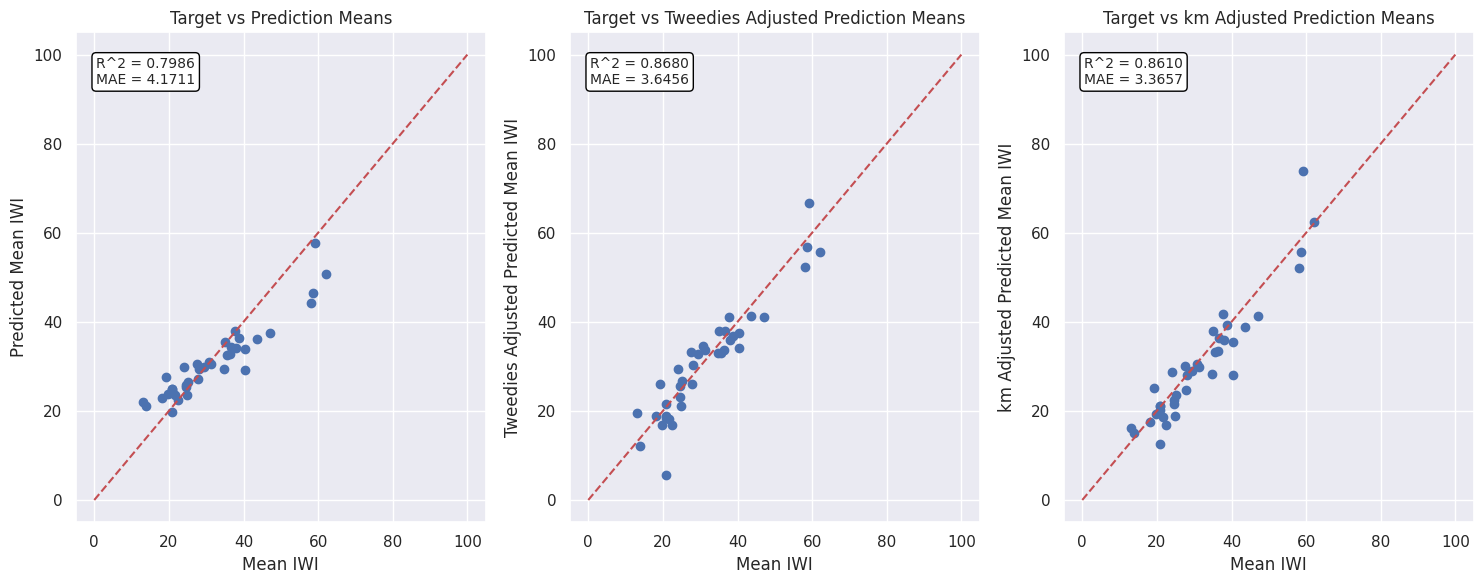

In [29]:
# Plot the target vs prediction means
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
plt.scatter(target_means, prediction_means)
# Add label with r^2 and MAE to plot
r2 = r2_score(target_means, prediction_means)
mae = mean_absolute_error(target_means, prediction_means)
plt.text(0.05, 0.95, f'R^2 = {r2:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([0, 100], [0, 100], 'r--')
plt.xlabel('Mean IWI')
plt.ylabel('Predicted Mean IWI')
plt.title('Target vs Prediction Means')

plt.subplot(1, 3, 2)
plt.scatter(target_means, adjusted_prediction_means)
# Add label with r^2 and MAE to plot
r2 = r2_score(target_means, adjusted_prediction_means)
mae = mean_absolute_error(target_means, adjusted_prediction_means)
plt.text(0.05, 0.95, f'R^2 = {r2:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([0, 100], [0, 100], 'r--')
plt.xlabel('Mean IWI')
plt.ylabel('Tweedies Adjusted Predicted Mean IWI')
plt.title('Target vs Tweedies Adjusted Prediction Means')

plt.subplot(1, 3, 3)
plt.scatter(target_means, km_prediction_means)
# Add label with r^2 and MAE to plot
r2 = r2_score(target_means, km_prediction_means)
mae = mean_absolute_error(target_means, km_prediction_means)
plt.text(0.05, 0.95, f'R^2 = {r2:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([0, 100], [0, 100], 'r--')
plt.xlabel('Mean IWI')
plt.ylabel('km Adjusted Predicted Mean IWI')
plt.title('Target vs km Adjusted Prediction Means')
plt.tight_layout()
plt.show()

In [31]:
print("F-statistic for target vs prediction means:")
f_statistic(target_means, prediction_means)
print('')
print("F-statistic for target vs Tweedies adjusted prediction means:")
f_statistic(target_means, adjusted_prediction_means)
print('')
print("F-statistic for target vs km adjusted prediction means:")
f_statistic(target_means, km_prediction_means)

F-statistic for target vs prediction means:
Estimated slope (k):, 0.6189
Estimated intercept (m):, 11.1948
RSS of Restricted model (k=1, m=0):, 1192.7996
RSS of Unrestricted model:, 297.3395
F-statistic:, 54.2083
p-value:, 0.0000

F-statistic for target vs Tweedies adjusted prediction means:
Estimated slope (k):, 0.9467
Estimated intercept (m):, 0.9575
RSS of Restricted model (k=1, m=0):, 781.9340
RSS of Unrestricted model:, 744.1028
F-statistic:, 0.9151
p-value:, 0.4096

F-statistic for target vs km adjusted prediction means:
Estimated slope (k):, 0.9929
Estimated intercept (m):, -1.0085
RSS of Restricted model (k=1, m=0):, 823.4819
RSS of Unrestricted model:, 765.2441
F-statistic:, 1.3699
p-value:, 0.2671


## Out-of-country model

We try doing the same thing, but without including the target country in the training set. This doesn't seem to work, which is not that strange considering the domain shift.

  0%|          | 0/38 [00:00<?, ?it/s]

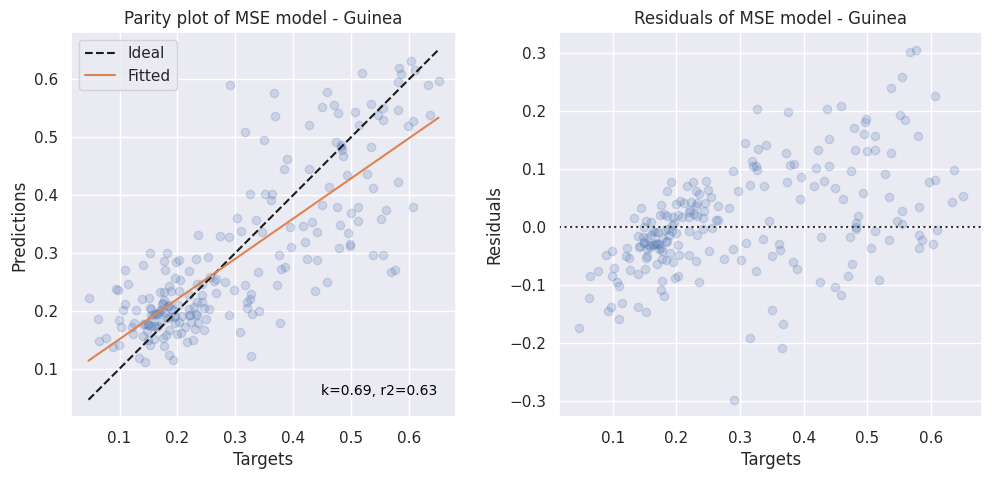

  3%|▎         | 1/38 [00:16<09:57, 16.15s/it]

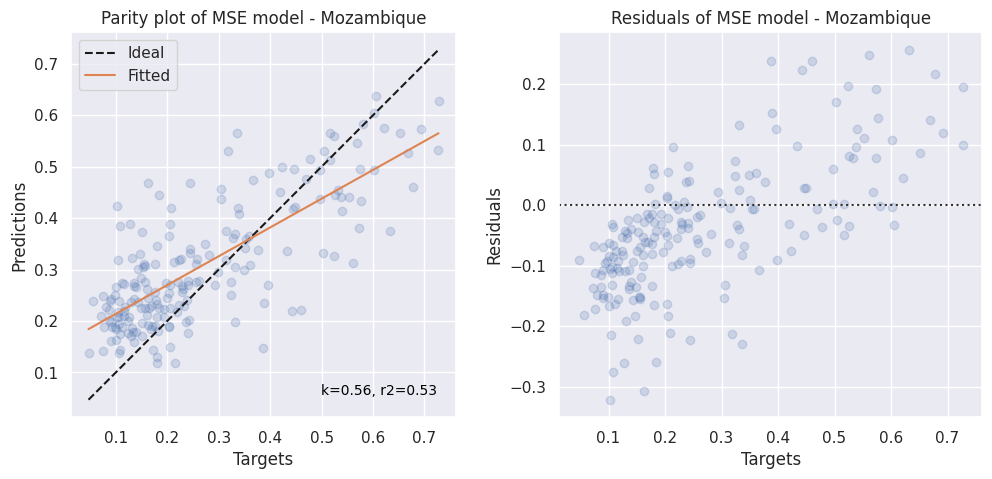

  5%|▌         | 2/38 [00:35<10:45, 17.94s/it]

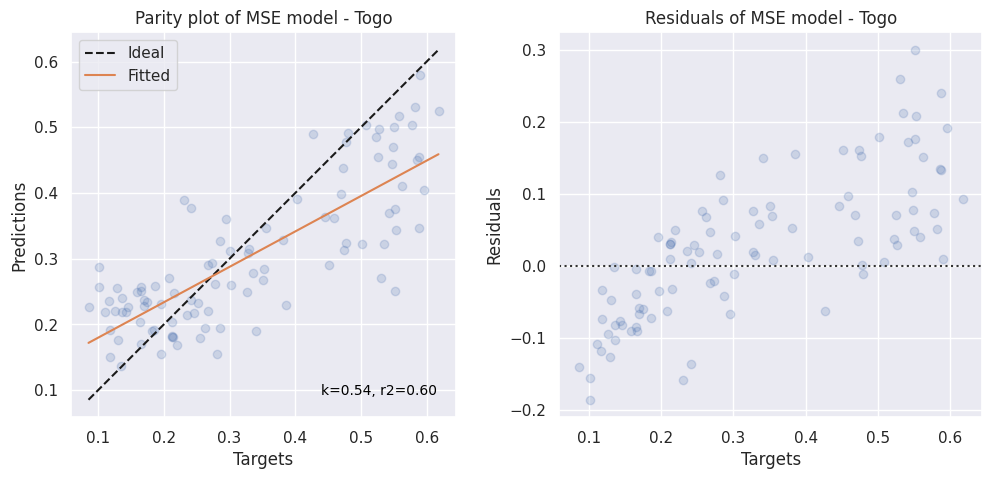

  8%|▊         | 3/38 [00:52<10:10, 17.44s/it]

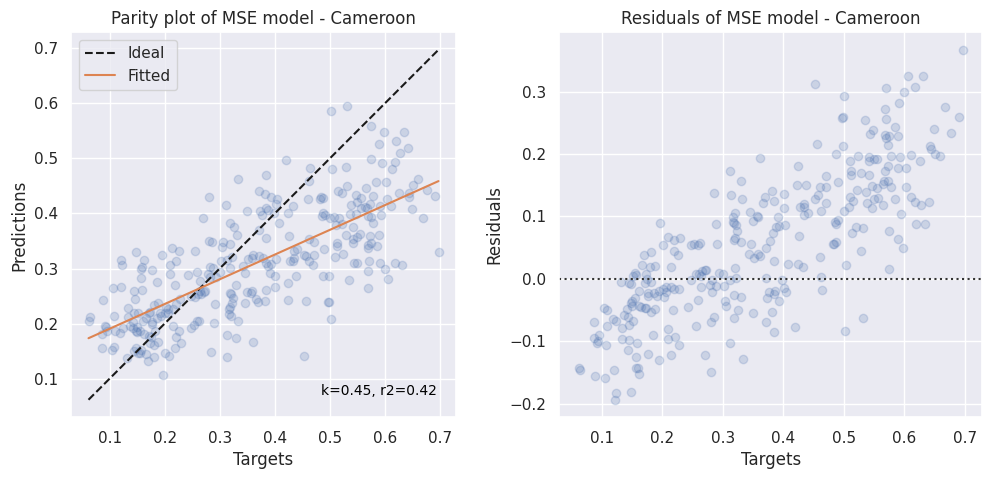

 11%|█         | 4/38 [01:08<09:38, 17.00s/it]

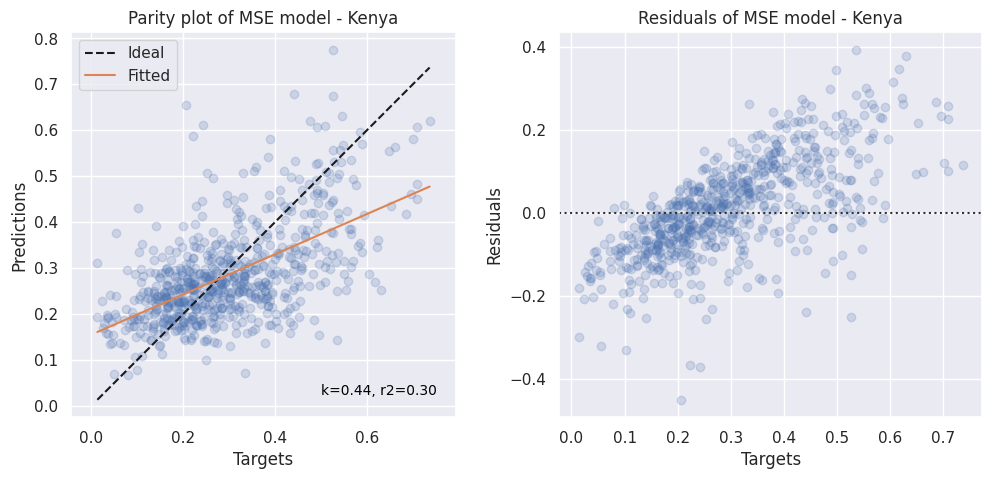

 13%|█▎        | 5/38 [01:23<09:00, 16.39s/it]

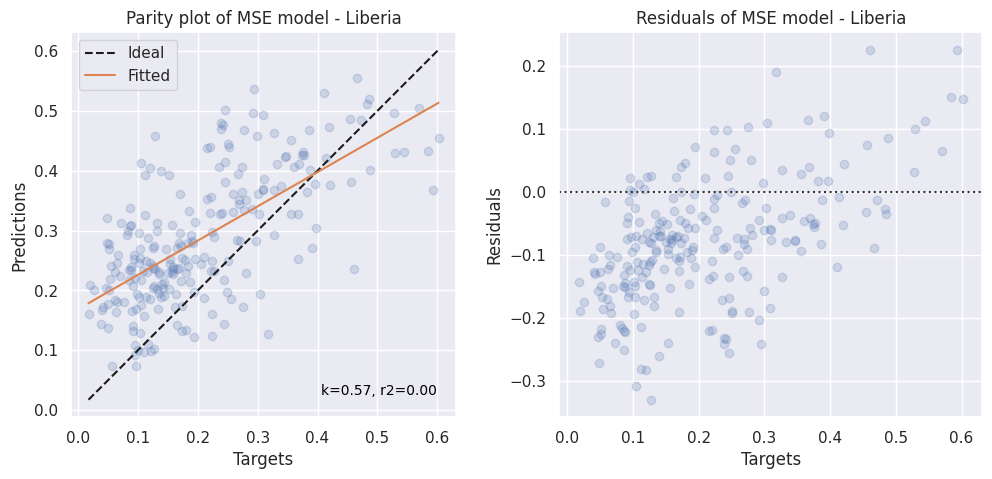

 16%|█▌        | 6/38 [01:38<08:23, 15.74s/it]

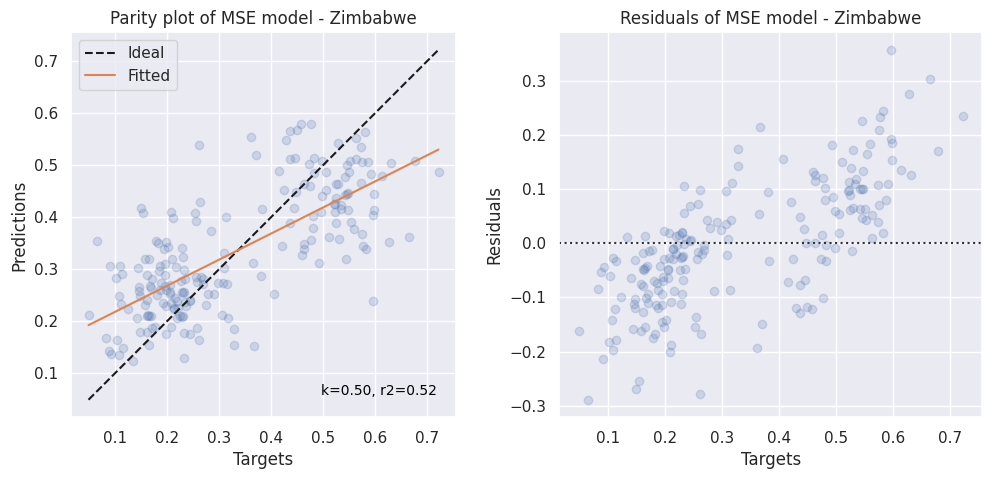

 18%|█▊        | 7/38 [01:53<08:05, 15.66s/it]

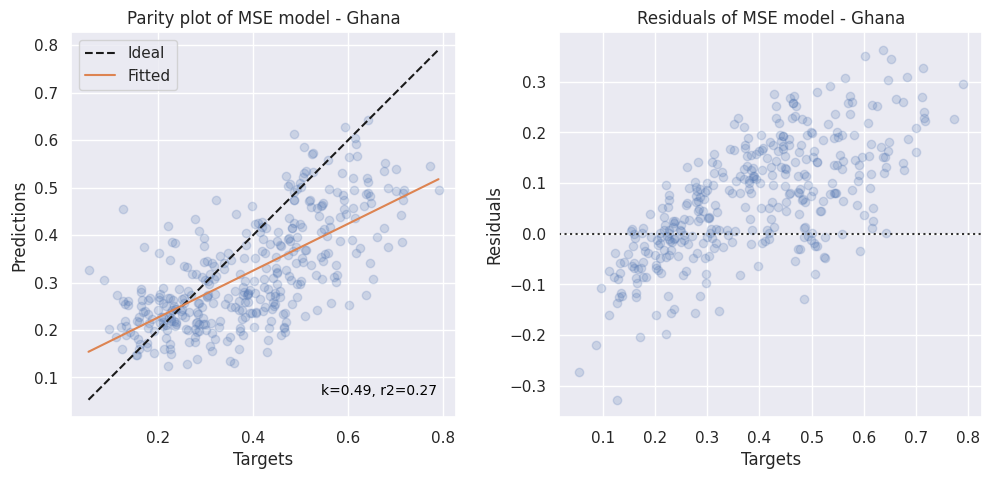

 21%|██        | 8/38 [02:11<08:07, 16.25s/it]

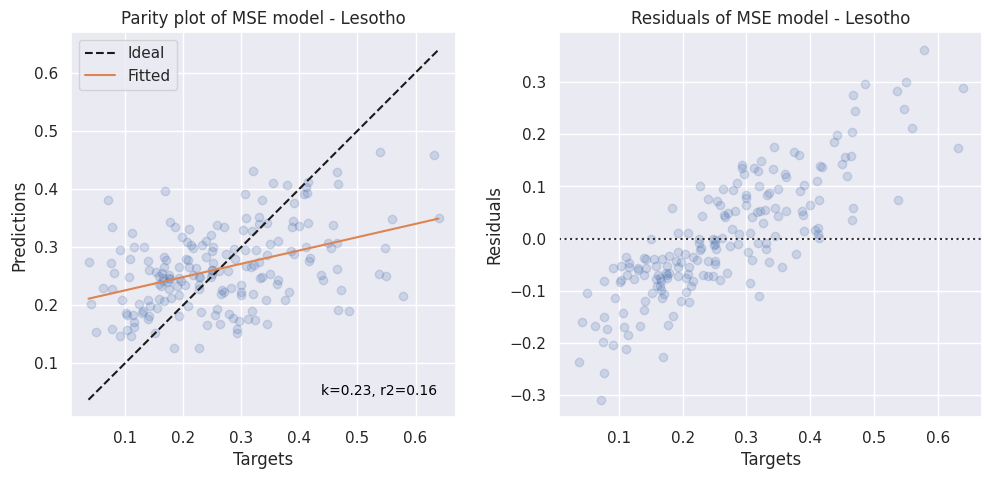

 24%|██▎       | 9/38 [02:30<08:20, 17.27s/it]

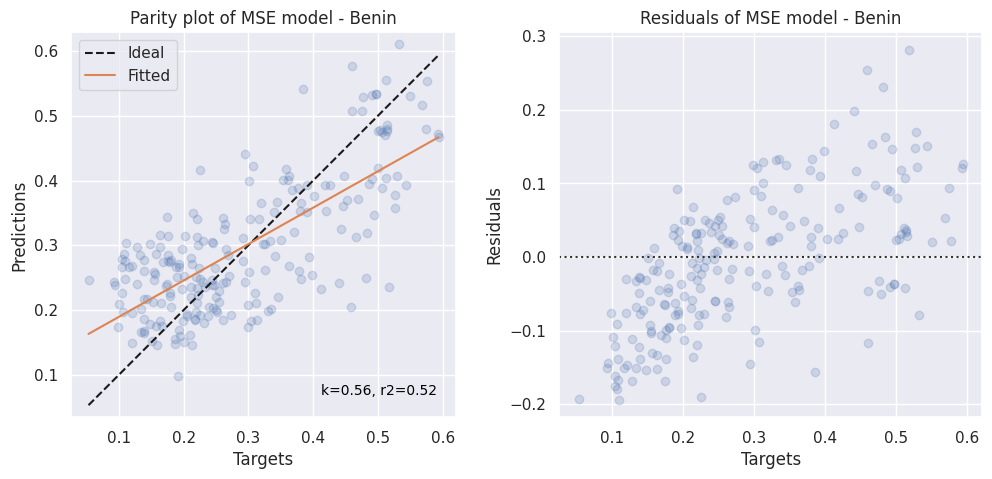

 26%|██▋       | 10/38 [02:48<08:03, 17.26s/it]

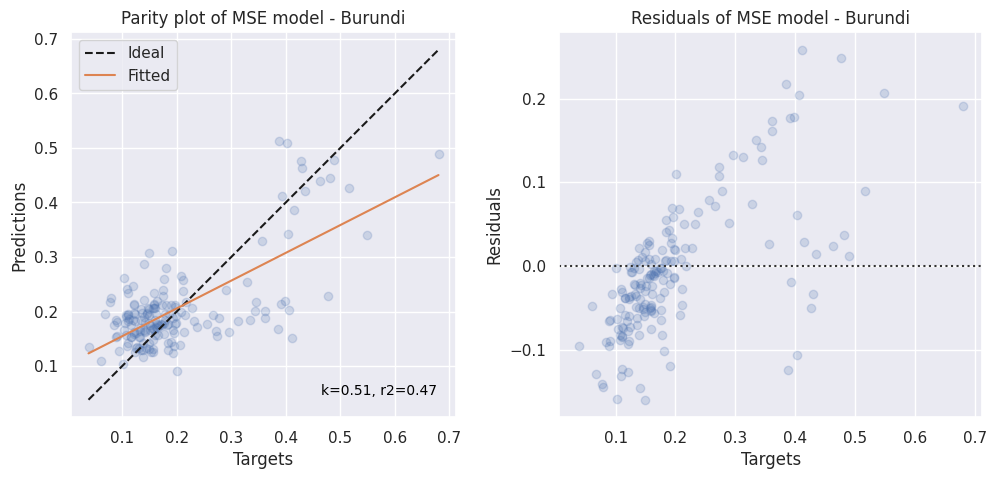

 29%|██▉       | 11/38 [03:04<07:41, 17.10s/it]

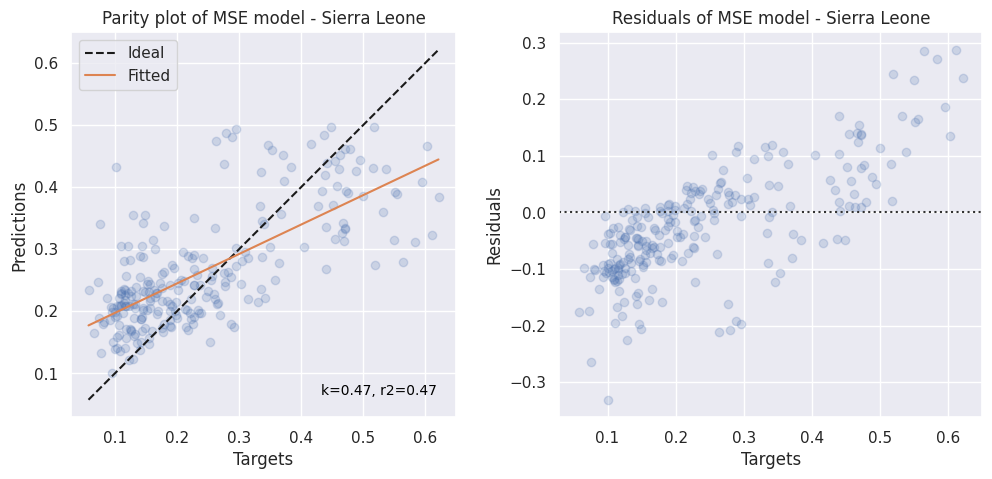

 32%|███▏      | 12/38 [03:21<07:23, 17.06s/it]

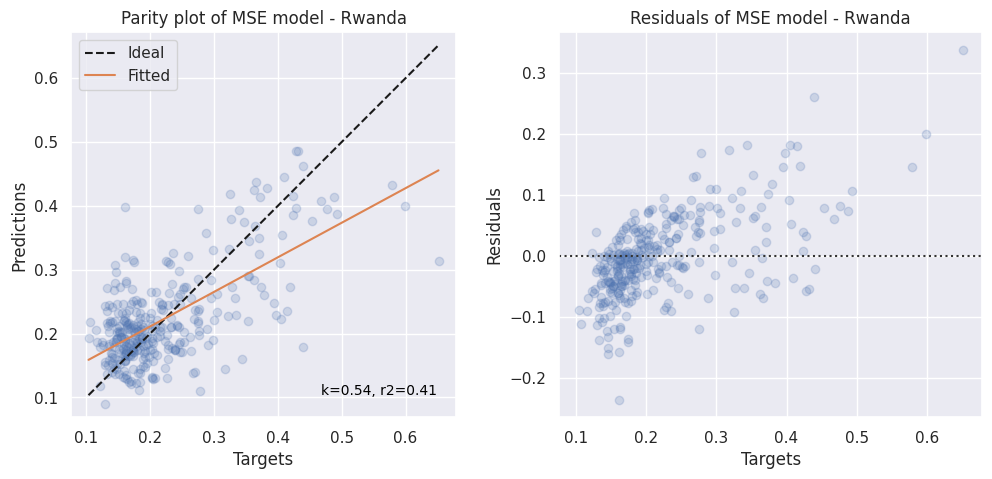

 34%|███▍      | 13/38 [03:37<06:59, 16.78s/it]

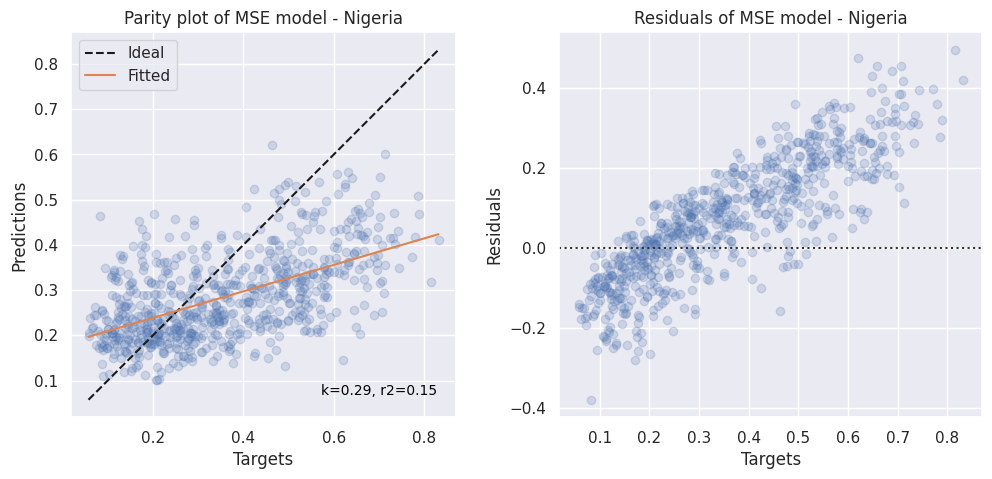

 37%|███▋      | 14/38 [03:52<06:29, 16.24s/it]

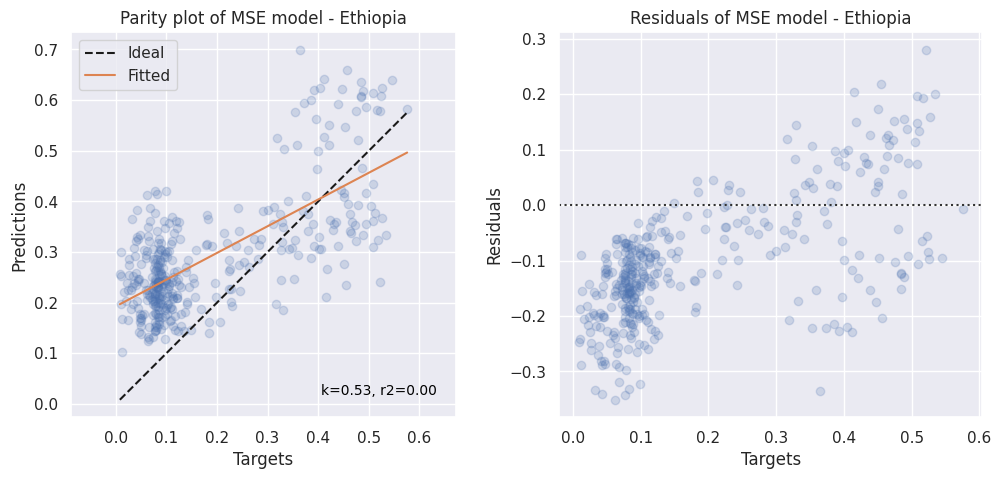

 39%|███▉      | 15/38 [04:06<05:53, 15.37s/it]

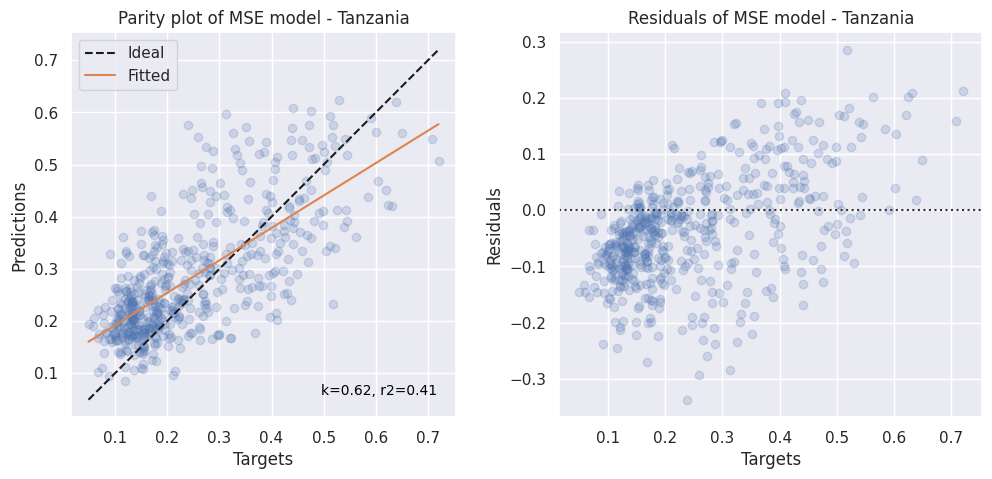

 42%|████▏     | 16/38 [04:23<05:47, 15.82s/it]

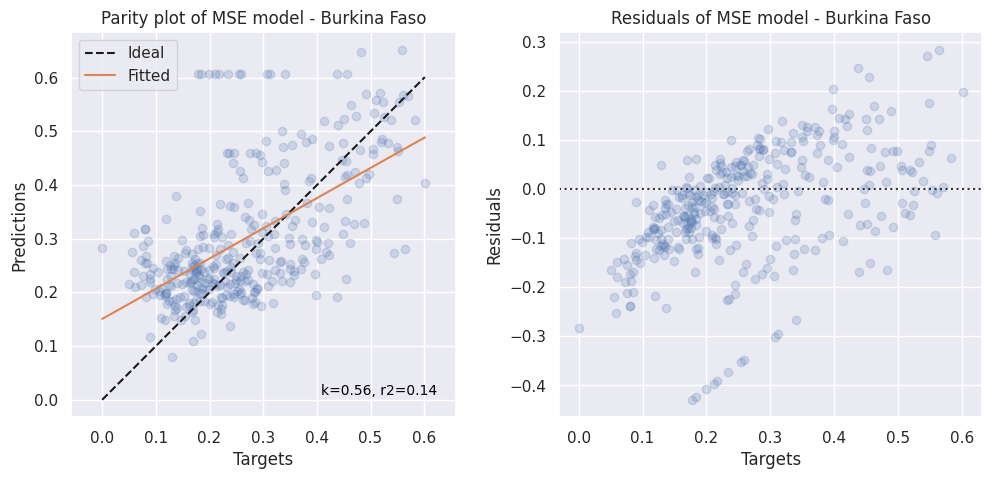

 45%|████▍     | 17/38 [04:38<05:28, 15.62s/it]

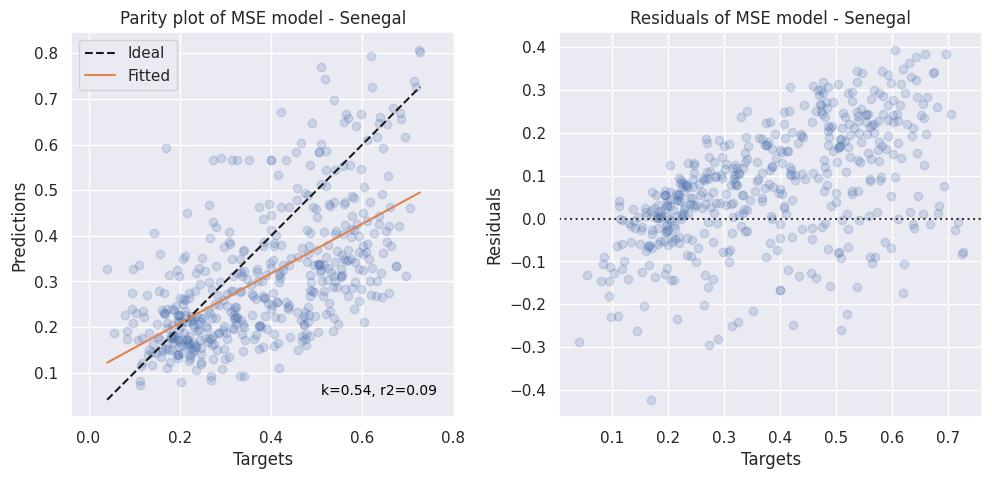

 47%|████▋     | 18/38 [04:52<05:06, 15.33s/it]

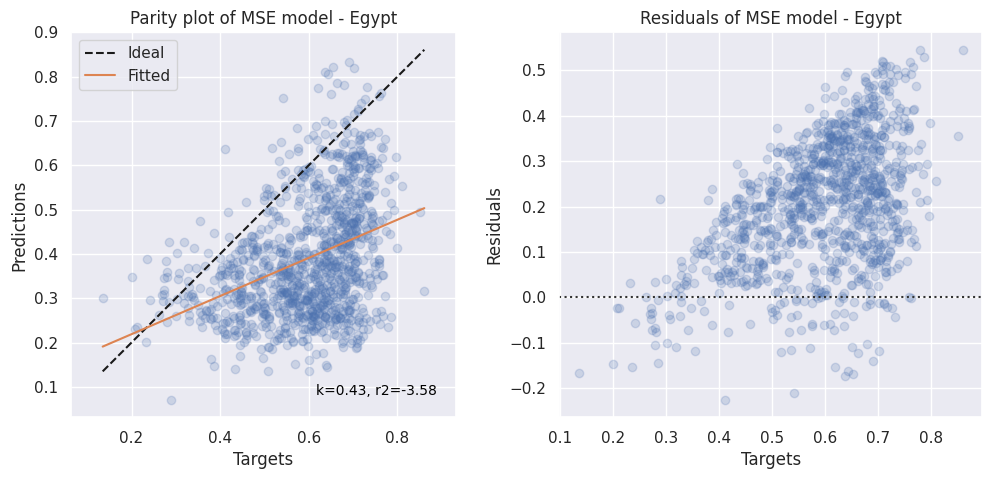

 50%|█████     | 19/38 [05:07<04:44, 14.96s/it]

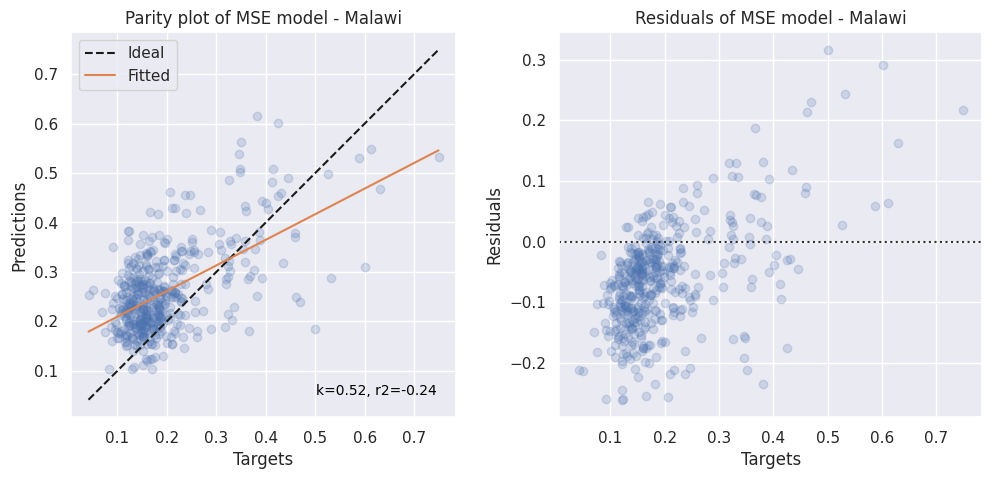

 53%|█████▎    | 20/38 [05:25<04:46, 15.89s/it]

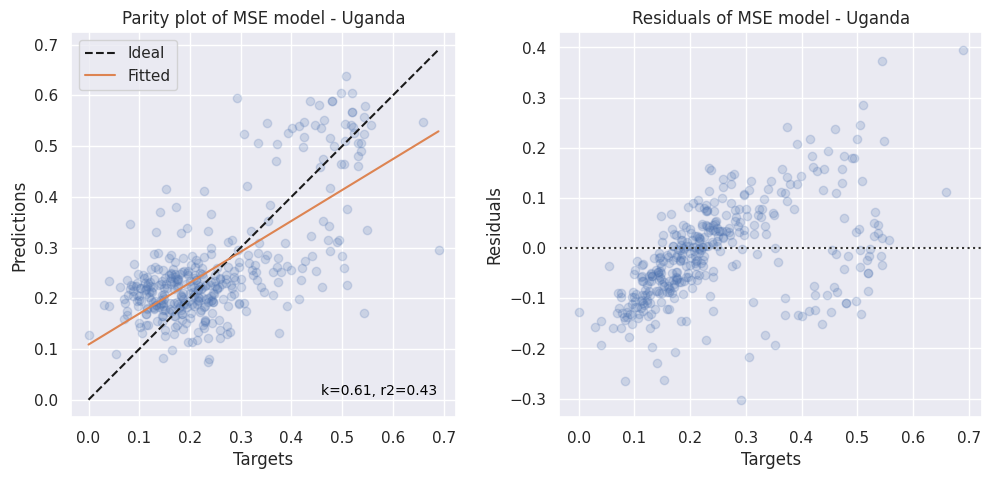

 55%|█████▌    | 21/38 [05:38<04:17, 15.14s/it]

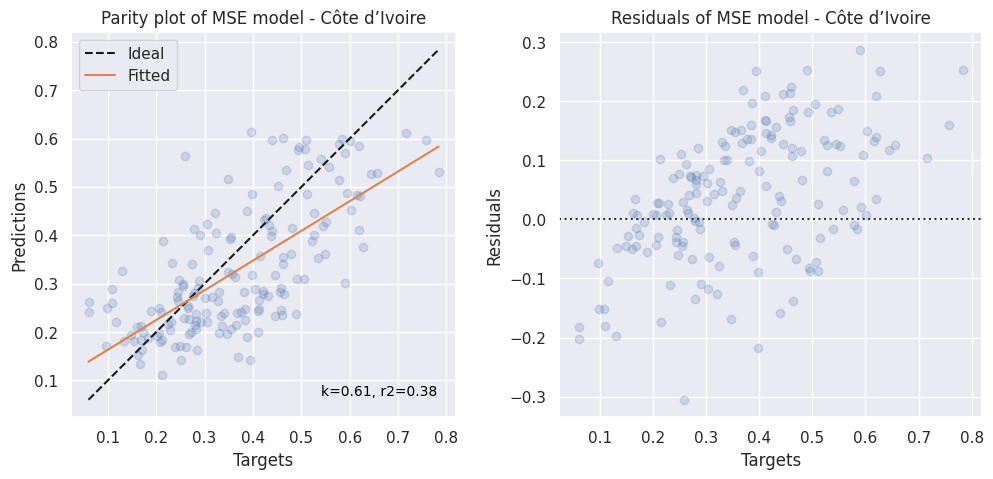

 58%|█████▊    | 22/38 [05:57<04:20, 16.30s/it]

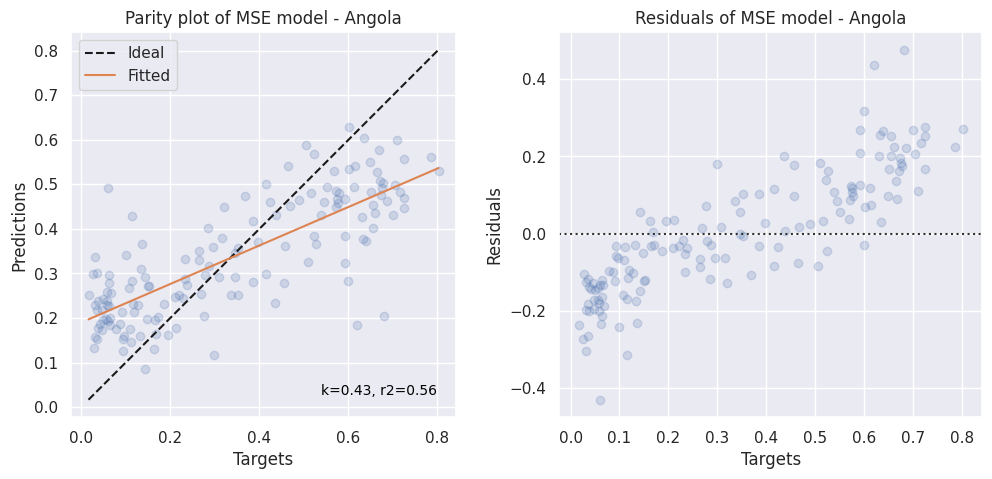

 61%|██████    | 23/38 [06:11<03:51, 15.47s/it]

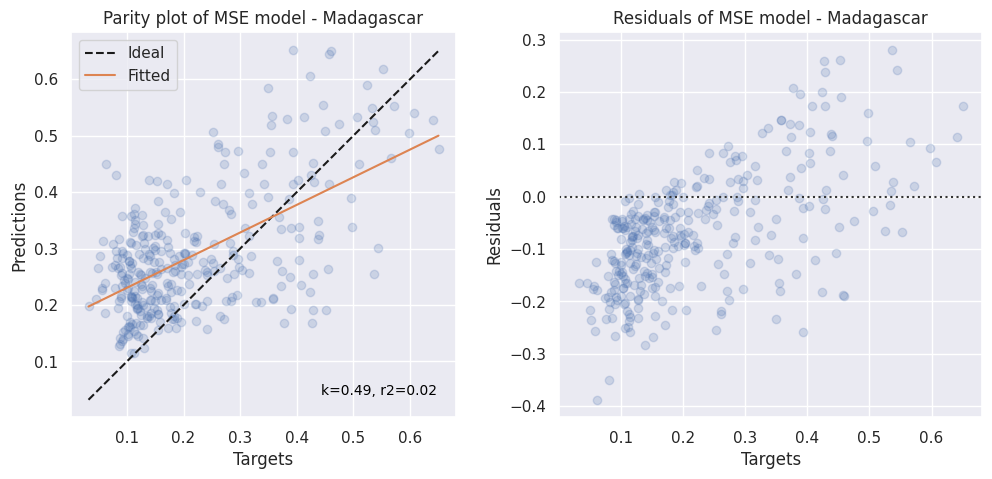

 63%|██████▎   | 24/38 [06:29<03:50, 16.49s/it]

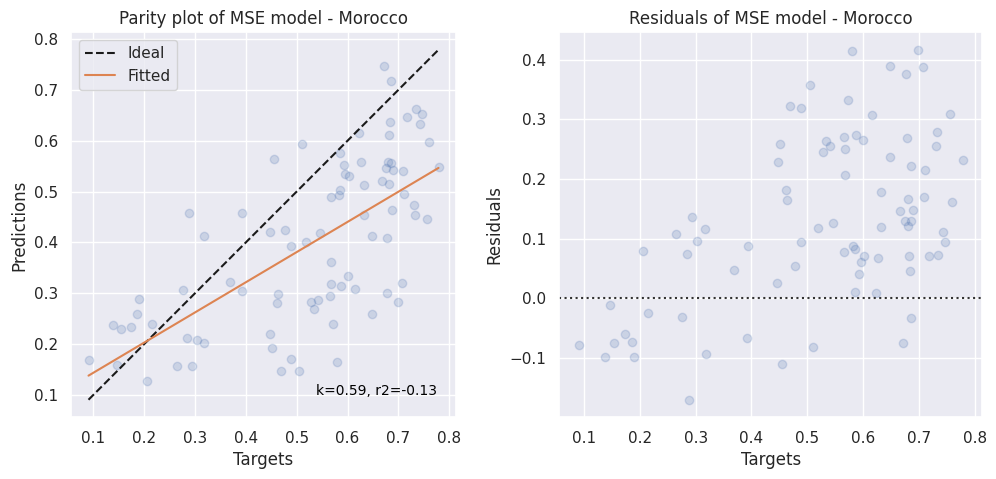

 66%|██████▌   | 25/38 [06:44<03:26, 15.91s/it]

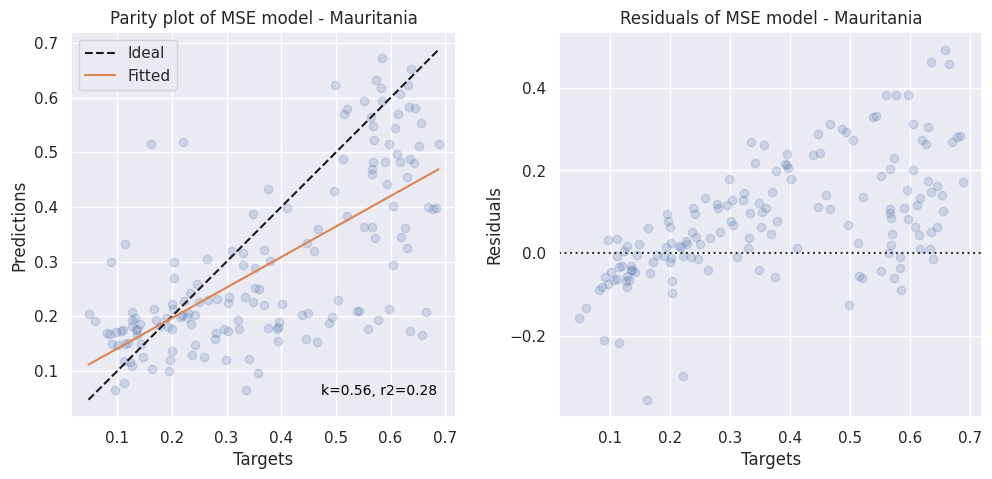

 68%|██████▊   | 26/38 [06:57<03:00, 15.01s/it]

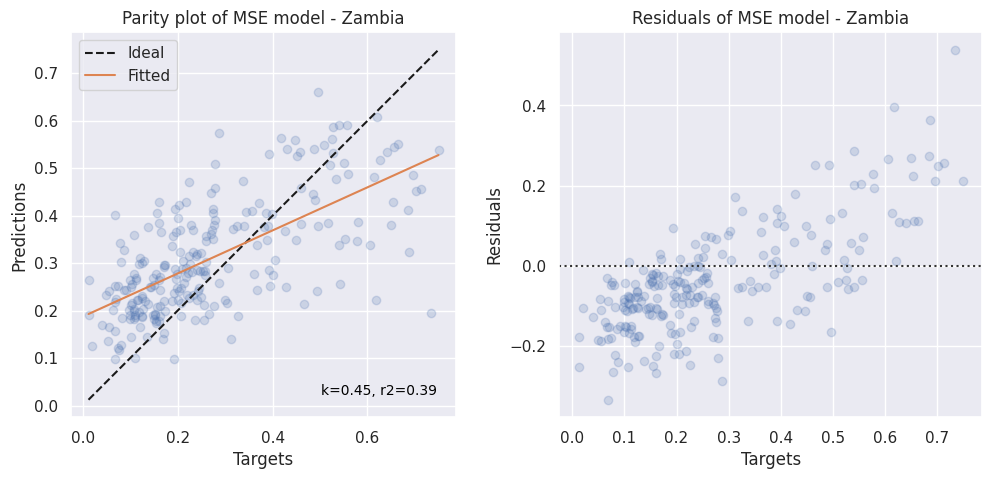

 71%|███████   | 27/38 [07:11<02:41, 14.64s/it]

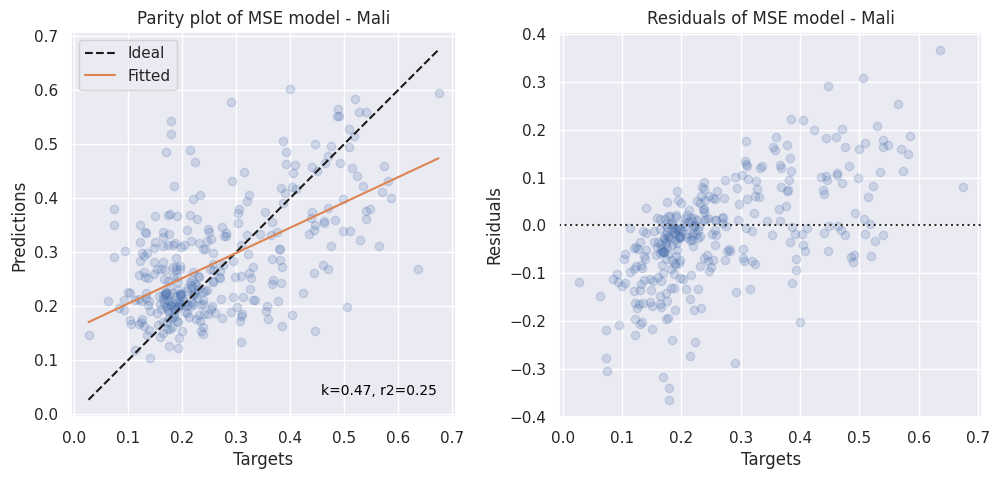

 74%|███████▎  | 28/38 [07:25<02:25, 14.54s/it]

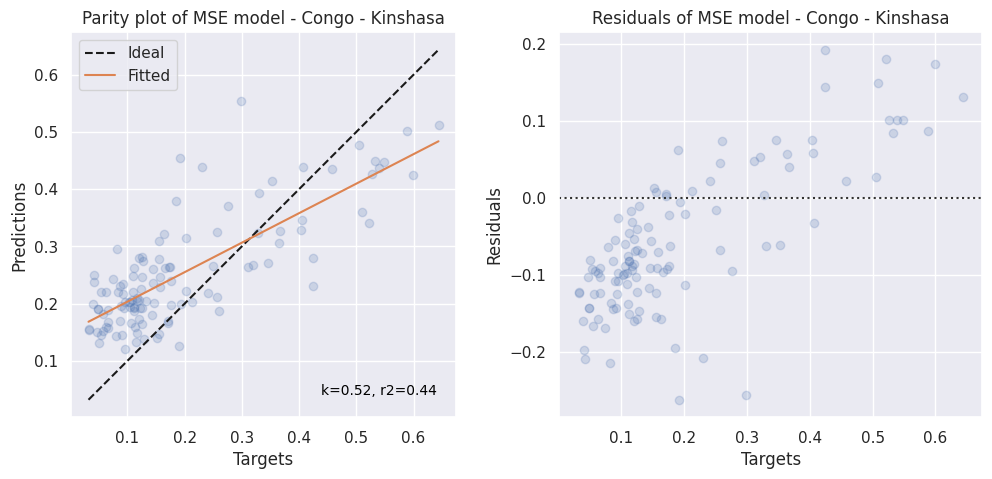

 76%|███████▋  | 29/38 [07:45<02:25, 16.13s/it]

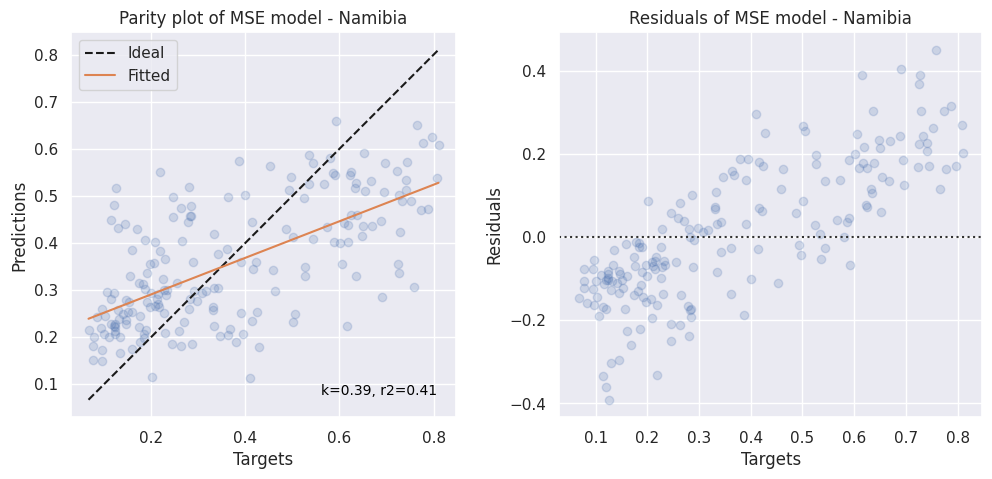

 79%|███████▉  | 30/38 [07:57<02:00, 15.02s/it]

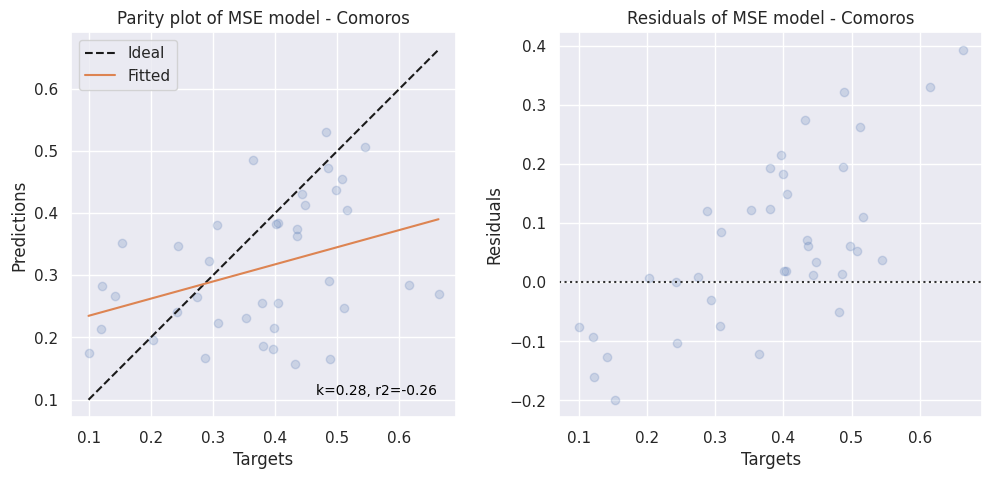

 82%|████████▏ | 31/38 [08:15<01:50, 15.81s/it]

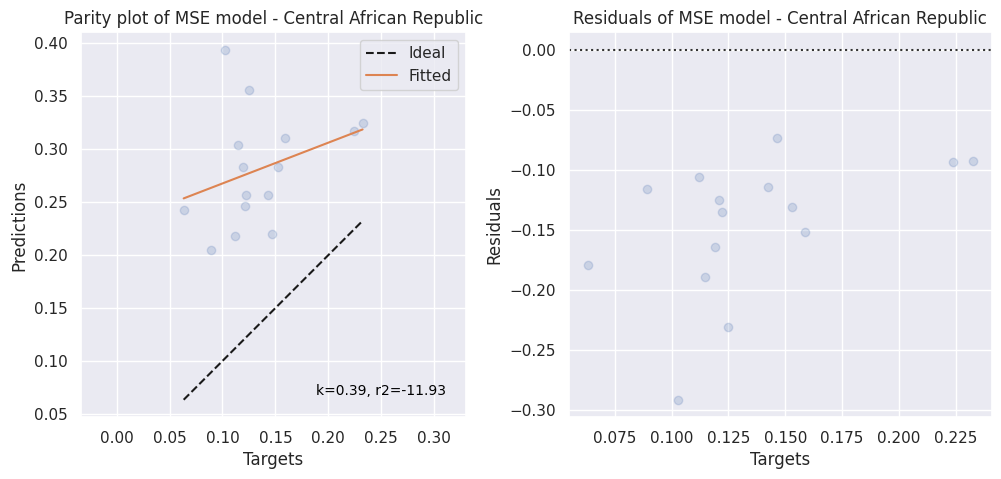

 84%|████████▍ | 32/38 [08:33<01:38, 16.42s/it]

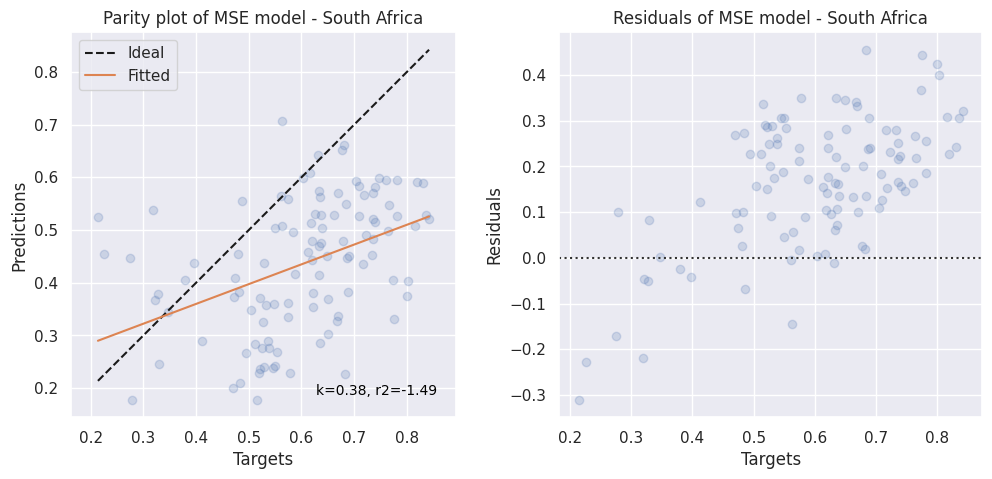

 87%|████████▋ | 33/38 [08:47<01:18, 15.78s/it]

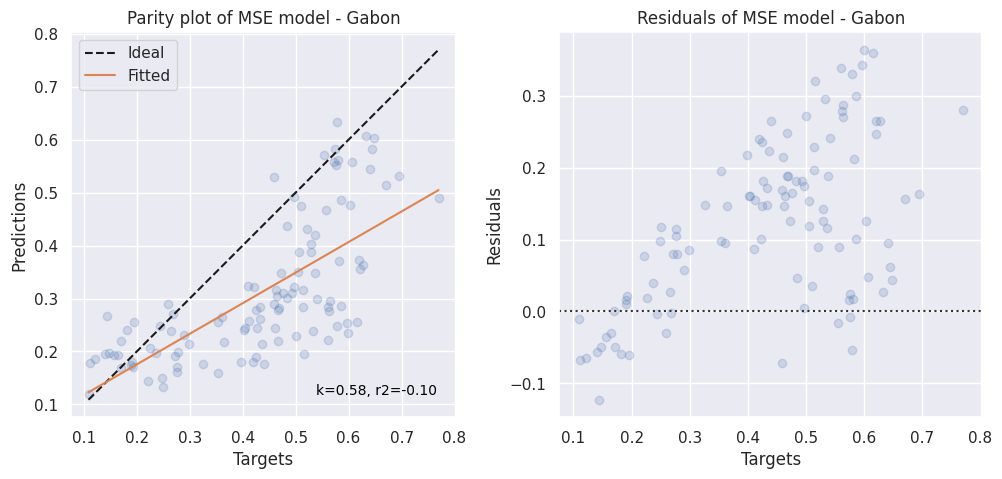

 89%|████████▉ | 34/38 [09:03<01:03, 15.76s/it]

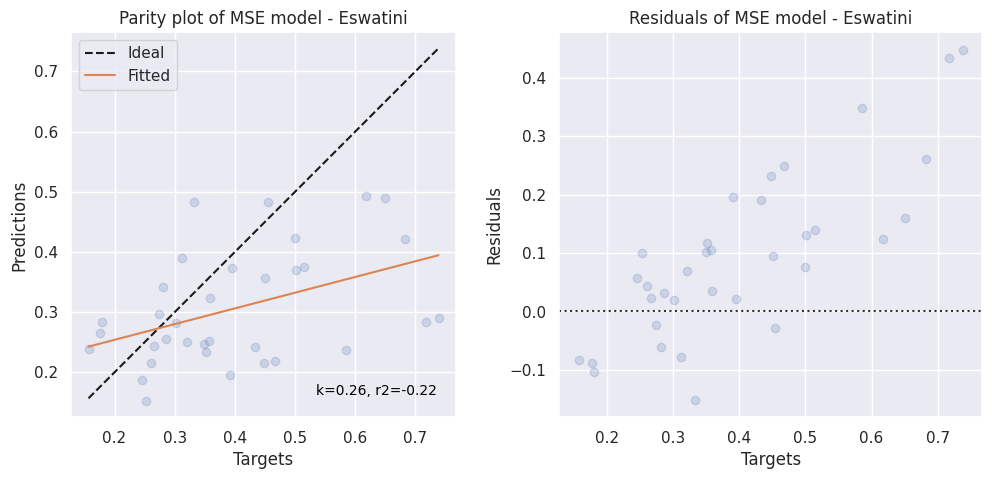

 92%|█████████▏| 35/38 [09:20<00:48, 16.08s/it]

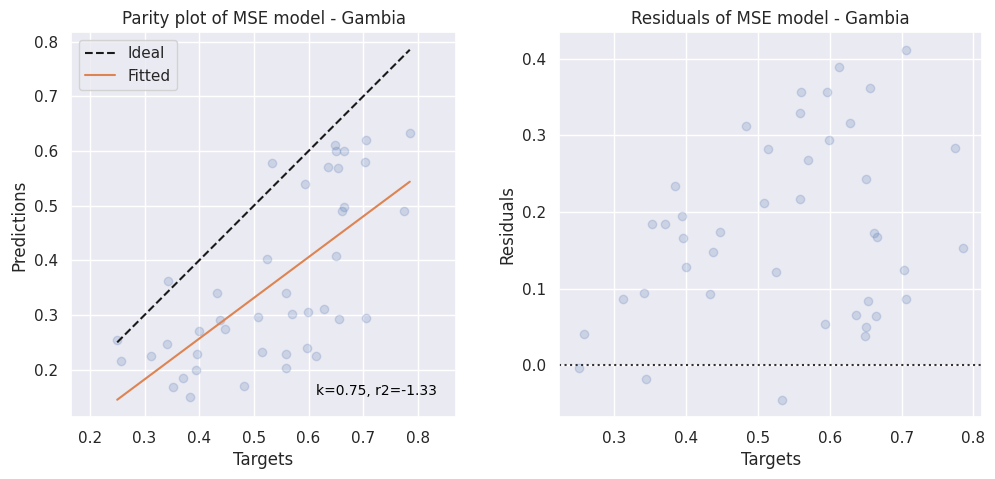

 95%|█████████▍| 36/38 [09:40<00:34, 17.31s/it]

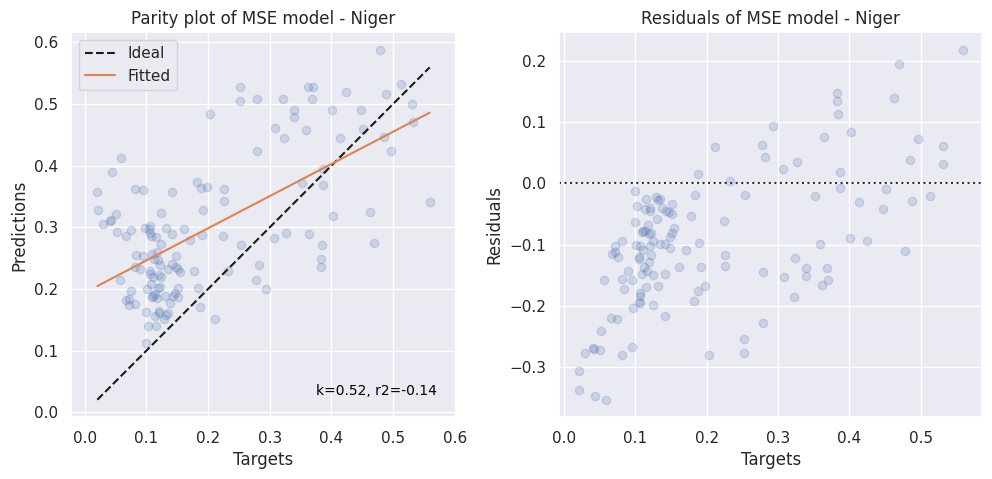

 97%|█████████▋| 37/38 [09:55<00:16, 16.68s/it]

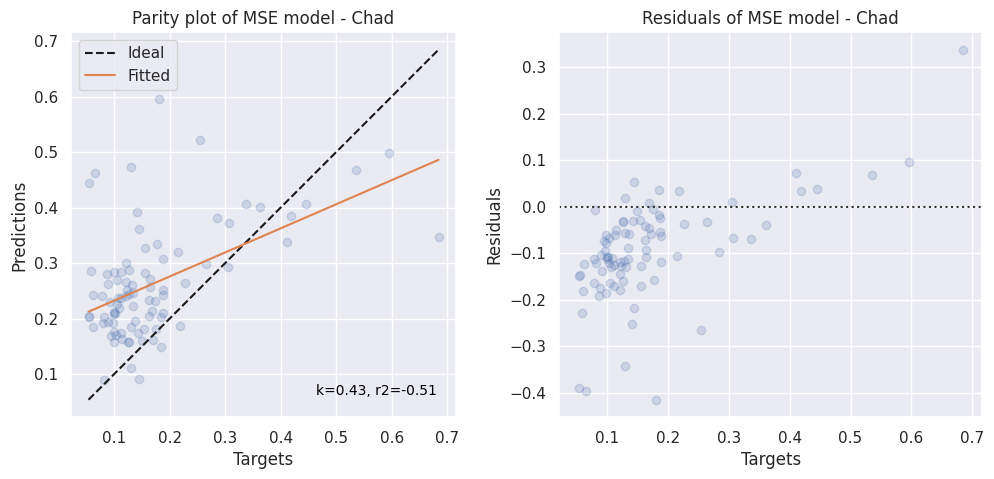

100%|██████████| 38/38 [10:07<00:00, 16.00s/it]


In [ ]:
def ooc_performance(X, Y, df, country):

    # Filter data for the selected country
    country_mask = df['country'] == country

    # Split data into train, validation, and test sets
    X_test = X[country_mask]
    y_test = Y[country_mask]
    df_test = df[country_mask]

    X_train = X[~country_mask]
    y_train = Y[~country_mask]
    df_train = df[~country_mask]

    X_train, X_val, y_train, y_val, df_train, df_val = train_test_split(X_train, y_train, df_train, test_size=0.2, random_state=RANDOM_STATE)

    # Train model
    mse_model = train_model(X_train, X_val, y_train, y_val, lr=1e-4, l2=1e-2, loss_fn=mse_loss, verbose=0)

    with torch.no_grad():
        y_pred = mse_model(X_test)
    
    plot_results(y_test, y_pred, f'MSE model - {country}')
    plt.show()

for country in tqdm(df['country'].unique()):
    ooc_performance(X, Y, df, country)
    

In [35]:
def run_ooc(X, Y, df, country):

    # Filter data for the selected country
    country_mask = df['country'] == country

    # Split data into train, validation, and test sets
    X_test = X[country_mask]
    y_test = Y[country_mask]
    df_test = df[country_mask]

    X_train = X[~country_mask]
    y_train = Y[~country_mask]
    df_train = df[~country_mask]

    X_train, X_val, y_train, y_val, df_train, df_val = train_test_split(X_train, y_train, df_train, test_size=0.2, random_state=RANDOM_STATE)

    # Train model
    mse_model = train_model(X_train, X_val, y_train, y_val, lr=1e-4, l2=1e-2, loss_fn=mse_loss, verbose=0)

    with torch.no_grad():
        y_pred = mse_model(X_test)
        val_predictions = mse_model(X_val)

    targets = 100 * y_test.cpu().numpy()
    predictions = 100 * y_pred.cpu().numpy()
    val_targets = 100 * y_val.cpu().numpy()
    val_predictions = 100 * val_predictions.cpu().numpy()

    pred_kde = gaussian_kde(predictions)
    val_pred_kde = gaussian_kde(val_predictions)
    prediction_scores = np.array([score_function(y, pred_kde) for y in predictions])
    val_prediction_scores = np.array([score_function(y, val_pred_kde) for y in val_predictions])
    res_std = (val_predictions - val_targets).std()

    target_mean = targets.mean()
    pred_mean = predictions.mean()

    adjusted_pred_mean = pred_mean - res_std**2 * prediction_scores.mean()
    adjusted_val_pred_mean = pred_mean - res_std**2 * val_prediction_scores.mean()

    return target_mean, pred_mean, adjusted_pred_mean, adjusted_val_pred_mean
    
target_means = []
prediction_means = []
adjusted_prediction_means = []
adjusted_val_prediction_means = []

# Run out-of-country estimates for each country
for country in tqdm(df['country'].unique()):
    c_target_mean, c_pred_mean, c_adjusted_pred_mean, adjusted_val_pred_mean = run_ooc(X, Y, df, country)
    target_means.append(c_target_mean)
    prediction_means.append(c_pred_mean)
    adjusted_prediction_means.append(c_adjusted_pred_mean)
    adjusted_val_prediction_means.append(adjusted_val_pred_mean)

target_means = np.array(target_means)
prediction_means = np.array(prediction_means)
adjusted_prediction_means = np.array(adjusted_prediction_means)
adjusted_val_prediction_means = np.array(adjusted_val_prediction_means)

  0%|          | 0/38 [00:00<?, ?it/s]

100%|██████████| 38/38 [09:54<00:00, 15.65s/it]


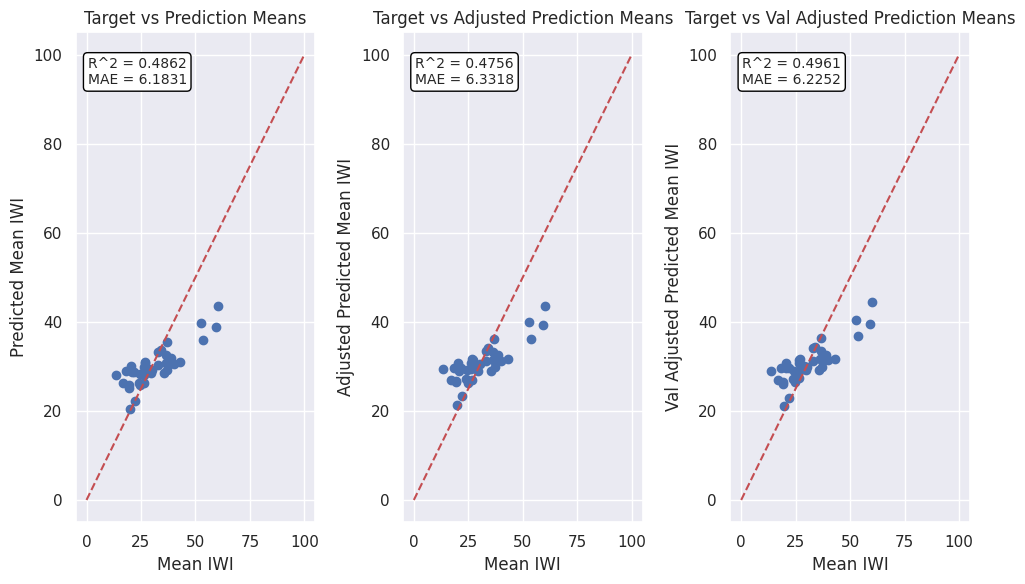

In [36]:
# Plot the target vs prediction means
plt.figure(figsize=(10, 6))
plt.subplot(1, 3, 1)
plt.scatter(target_means, prediction_means)
# Add label with r^2 and MAE to plot
r2 = r2_score(target_means, prediction_means)
mae = mean_absolute_error(target_means, prediction_means)
plt.text(0.05, 0.95, f'R^2 = {r2:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([0, 100], [0, 100], 'r--')
plt.xlabel('Mean IWI')
plt.ylabel('Predicted Mean IWI')
plt.title('Target vs Prediction Means')

plt.subplot(1, 3, 2)
plt.scatter(target_means, adjusted_prediction_means)
# Add label with r^2 and MAE to plot
r2 = r2_score(target_means, adjusted_prediction_means)
mae = mean_absolute_error(target_means, adjusted_prediction_means)
plt.text(0.05, 0.95, f'R^2 = {r2:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([0, 100], [0, 100], 'r--')
plt.xlabel('Mean IWI')
plt.ylabel('Adjusted Predicted Mean IWI')
plt.title('Target vs Adjusted Prediction Means')

plt.subplot(1, 3, 3)
plt.scatter(target_means, adjusted_val_prediction_means)
# Add label with r^2 and MAE to plot
r2 = r2_score(target_means, adjusted_val_prediction_means)
mae = mean_absolute_error(target_means, adjusted_val_prediction_means)
plt.text(0.05, 0.95, f'R^2 = {r2:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
plt.plot([0, 100], [0, 100], 'r--')
plt.xlabel('Mean IWI')
plt.ylabel('Val Adjusted Predicted Mean IWI')
plt.title('Target vs Val Adjusted Prediction Means')
plt.tight_layout()
plt.show()